# Convolutional autoencoder for removing noise from images
### Ref. Deep Learning with TensorFlow 2 and Keras ch.9

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D

### Hyperparameters

In [2]:
np.random.seed(11)
tf.random.set_seed(11)
batch_size = 128
max_epochs = 50
filters = [32, 32, 16]

### Read the MNIST dataset, normalize it, and introduce noise in it

In [3]:
(x_train, _), (x_test, _) = K.datasets.mnist.load_data()

x_train = x_train / 255.0
x_test = x_test / 255.0

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

noise = 0.5
x_train_noisy = x_train + noise * np.random.normal(loc= 0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise * np.random.normal(loc= 0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0, 1)
x_test_noisy = np.clip(x_test_noisy, 0, 1)

x_train_noisy = x_train_noisy.astype('float32')
x_test_noisy = x_test_noisy.astype('float32')


In [4]:
class Encoder(K.layers.Layer):
    def __init__(self, filters) -> None:
        super(Encoder, self).__init__()
        self.conv1 = Conv2D(filters = filters[0], kernel_size=3, strides=1, activation='relu', padding='same')
        self.conv2 = Conv2D(filters = filters[1], kernel_size=3, strides=1, activation='relu', padding='same')
        self.conv3 = Conv2D(filters = filters[2], kernel_size=3, strides=1, activation='relu', padding='same')
        self.pool = MaxPooling2D((2, 2), padding='same')

    def call(self, input_features):
        x = self.conv1(input_features)
        #print("Ex1", x.shape)
        x = self.pool(x)
        #print("Ex2", x.shape)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        return x


In [5]:
class Decoder(K.layers.Layer):
    def __init__(self, filters) -> None:
        super(Decoder, self).__init__()
        self.conv1 = Conv2D(filters = filters[2], kernel_size=3, strides=1, activation='relu', padding='same')
        self.conv2 = Conv2D(filters = filters[1], kernel_size=3, strides=1, activation='relu', padding='same')
        self.conv3 = Conv2D(filters = filters[0], kernel_size=3, strides=1, activation='relu', padding='valid')
        self.conv4 = Conv2D(1, 3, 1, activation='sigmoid', padding='same')
        self.upsample = UpSampling2D((2,2))
    
    def call(self, encoded):
        x = self.conv1(encoded)
        #print("Dx1", x.shape)
        x = self.upsample(x)
        #print("Dx2", x.shape)
        x = self.conv2(x)
        x = self.upsample(x)
        x = self.conv3(x)
        x = self.upsample(x)
        x = self.conv4(x)
        return x



In [6]:
class Autoencoder(K.Model):
    def __init__(self, filters) -> None:
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(filters)
        self.decoder = Decoder(filters)
    
    def call(self, input_features):
        encoded = self.encoder(input_features)
        reconstructed = self.decoder(encoded)
        return reconstructed

In [7]:
model = Autoencoder(filters)
model.compile(loss='binary_crossentropy', optimizer='adam')

loss = model.fit(
    x_train_noisy,    
    x_train,
    validation_data = (x_test_noisy, x_test),
    epochs=max_epochs,
    batch_size=batch_size
    )

Epoch 1/50
469/469 [==============================] - 80s 169ms/step - loss: 0.2048 - val_loss: 0.1504
Epoch 2/50
469/469 [==============================] - 78s 166ms/step - loss: 0.1420 - val_loss: 0.1324
Epoch 3/50
469/469 [==============================] - 77s 165ms/step - loss: 0.1289 - val_loss: 0.1247
Epoch 4/50
469/469 [==============================] - 75s 160ms/step - loss: 0.1221 - val_loss: 0.1197
Epoch 5/50
469/469 [==============================] - 75s 159ms/step - loss: 0.1179 - val_loss: 0.1152
Epoch 6/50
469/469 [==============================] - 74s 157ms/step - loss: 0.1149 - val_loss: 0.1137
Epoch 7/50
469/469 [==============================] - 74s 157ms/step - loss: 0.1126 - val_loss: 0.1108
Epoch 8/50
469/469 [==============================] - 74s 157ms/step - loss: 0.1111 - val_loss: 0.1096
Epoch 9/50
469/469 [==============================] - 73s 156ms/step - loss: 0.1097 - val_loss: 0.1082
Epoch 10/50
469/469 [==============================] - 73s 157ms/step - l

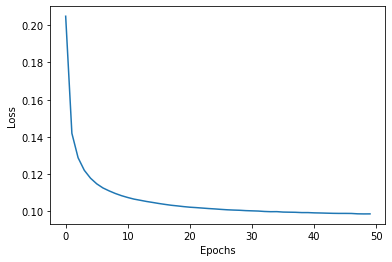

In [8]:
plt.plot(range(max_epochs), loss.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

ResourceExhaustedError: OOM when allocating tensor with shape[10000,28,28,32] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:Conv2D]

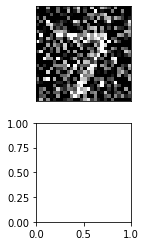

In [10]:
number = 10 # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test_noisy[index].reshape(28,28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(model(x_test_noisy)[index].numpy().reshape(28,28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)    